Many beginners comparing their result with the leaderboard have the impression that they are doing something wrong, but a result of about 77% is a normal one, the problem is to push it a few percents higher.

This notebook used the standard dataset and scored 0.81578 on the leaderboard that puts it in top 1% if we don't take into account the top positions that scored greater than 0.86 and are based on cheating or used an extended dataset. If somebody find a shared notebook with a real score of 0.86 send a link in comments please.

Have fun!

https://www.kaggle.com/code/alisalee/titanic-challenge

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostClassifier

# Load data and first look

In [6]:
# Load data
full_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Prepare dataframe for further manipulations

In [7]:
# Separate test_df PassengerId (will need it for submission)
test_pass_id = test_df.pop('PassengerId')

# Keep max index that will be used to back split training and test data
X_max_index = full_df.shape[0]

# Separate features and target
y = full_df.Survived

df = full_df.drop(['Survived', 'PassengerId'], axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


In [8]:
most_common_embarked = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(most_common_embarked)

In [9]:
np.random.randint(df['Age'].mean()-df['Age'].std(),df['Age'].mean() + df['Age'].std(),177)

array([25, 40, 28, 15, 20, 32, 39, 23, 24, 22, 23, 30, 17, 39, 18, 43, 43,
       33, 42, 34, 21, 40, 38, 38, 43, 30, 36, 31, 40, 31, 34, 32, 24, 22,
       17, 31, 22, 41, 20, 38, 37, 24, 23, 32, 39, 41, 15, 38, 23, 34, 41,
       36, 23, 21, 29, 25, 35, 27, 30, 30, 33, 23, 35, 28, 34, 31, 19, 39,
       22, 24, 23, 36, 33, 30, 42, 27, 39, 39, 32, 43, 26, 20, 39, 31, 35,
       35, 37, 33, 36, 38, 19, 41, 20, 24, 19, 40, 24, 20, 21, 33, 15, 38,
       28, 40, 20, 43, 19, 17, 19, 40, 29, 25, 19, 42, 39, 39, 41, 32, 37,
       33, 27, 28, 41, 37, 15, 20, 27, 24, 18, 29, 20, 23, 32, 27, 41, 38,
       26, 29, 39, 31, 23, 17, 39, 35, 28, 40, 23, 19, 38, 23, 27, 30, 16,
       23, 19, 29, 36, 35, 20, 41, 27, 41, 37, 18, 41, 43, 43, 26, 19, 20,
       32, 31, 16, 39, 41, 21, 36])

In [10]:
df_age = np.random.randint(df['Age'].mean()-df['Age'].std(),df['Age'].mean() + df['Age'].std(),177)

In [11]:
df_age = df['Age'].mean()

# Use this mean value to fill all NaN values in the 'Age' column
df.loc[df['Age'].isnull(), 'Age'] = df_age

- Some features need imputation
- Cabin column has a lot of missing values, we will use the availble 
  values to create a new feature and will drop Cabin
- We will create the feature Deck level, using the correlation between
  Pclass and info deducted from Cabin column. We suppose that the deck 
  level could take a role in survivability of the people as the lifeboats 
  were on the top level.
- From Name we will keep just the lastname and use it during creation 
  of Deck_level.
- We will create the feature Title, extracting the title from Name column, 
  supposing that some category of people had priority to embark the lifeboats.

# Unprocessed data correlation



In [12]:
#full_df.corr()['Survived'].sort_values(ascending=False)

- Fare and Pclass have the highest correlation to Survived, it seams higher class (also higher Fare) had priority to embarc the lifeboats.
- Pclass has negative correlation because Pclass is numbered 1, 2, 3 (high, medium, low), but results to an invers survivability (class 3 = lower chance to survive, class 1 = higher chance).

# Surviving distribution by Age and Sex

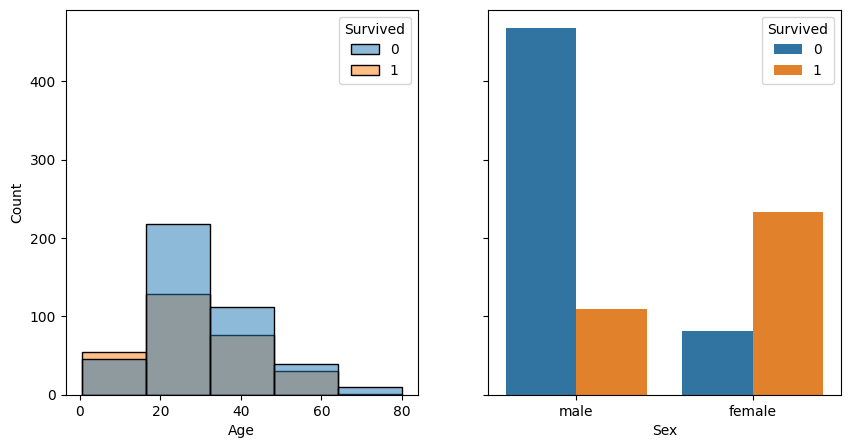

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(x='Age', hue='Survived', data=full_df, bins=5, ax=axs[0])
sns.countplot(x='Sex', hue='Survived', data=full_df, ax=axs[1])
plt.show()

Women and children definetely had more chances to survive

# Features' instances

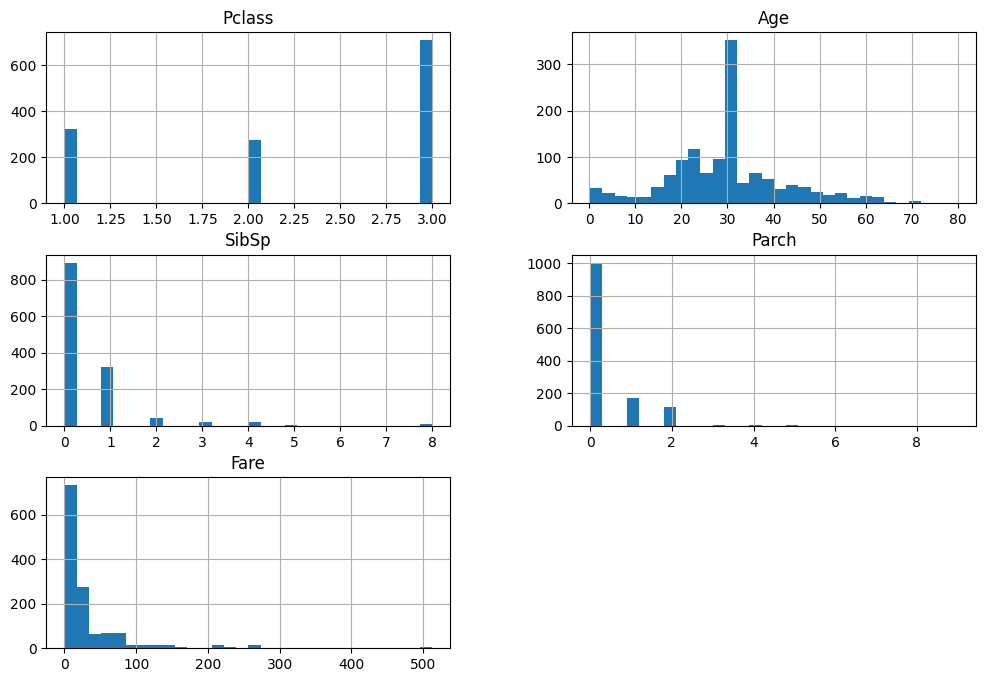

In [14]:
df.hist(bins=30, figsize=(12, 8))
plt.show()

- Attributes have different scales
- Some features are skewed right, we should check for outliers and normalize data
- Fare has values of 0 that looks weird

In [15]:
# Zero values in Fare we will consider as an error or outlier and will delete for further imputation
df.loc[df.Fare.eq(0), 'Fare'] = np.nan

# Create Lastname

In [16]:
df['Lastname'] = df.Name.str.split(', ').str[0]

# Create Title

In [17]:
# Extracting the Title from Name column
df['Title'] = df.Name.str.split(', ').str[1]
df['Title'] = df.Title.str.split('.').str[0]

In [18]:
# Analyze titles
df.Title.value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

We will simplify the titles to the same meaning ones

In [19]:
# Analyze the title Mr by Age
df[df.Title.eq('Mr')].Age.describe()

count    757.000000
mean      31.700899
std       10.926534
min       11.000000
25%       25.000000
50%       29.881138
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [20]:
# Analyze the title Master by Age
df[df.Title.eq('Master')].Age.describe()

count    61.000000
mean      8.682444
std       9.163600
min       0.330000
25%       2.000000
50%       6.000000
75%      11.000000
max      29.881138
Name: Age, dtype: float64

In [21]:
# Analyze the title Master by Age
df[df.Title.eq('Mrs')].Age.describe()

count    197.000000
mean      36.019242
std       12.228651
min       14.000000
25%       28.000000
50%       33.000000
75%       45.000000
max       76.000000
Name: Age, dtype: float64

In the dataset title Mr is used from 11 years old and Master to maximum 15 years old.

Master is an antiquated title for an underage male.

We will join them together and then split again at age 18 to have a clean delimeter between minor and adult male titles.

Miss is used for young ladies and also for unmarried ones

Title Mrs younger than 18 years we will change to Miss as more apropriate

In [22]:
# Grouping the same type titles 
mrs = ['Mrs', 'Mme']
df.loc[df.Title.isin(mrs), 'Title'] = 'Mrs'

miss = ['Ms', 'Miss', 'Mlle']
df.loc[df.Title.isin(miss), 'Title'] = 'Miss'

# Change minor Mr title to Master
df.loc[(df.Title.eq('Mr') & df.Age.le(18)), 'Title'] = 'Master'

# Change minor Mrs title to Miss
df.loc[(df.Title.eq('Mrs') & df.Age.le(18)), 'Title'] = 'Miss'

# Separate other titles by sex
df.loc[(~df.Title.isin(['Mrs', 'Miss', 'Mr', 'Master']) 
        & df.Sex.eq('male')), 'Title'] = 'Mr'

df.loc[(~df.Title.isin(['Mrs', 'Miss', 'Mr', 'Master']) 
        & df.Sex.eq('female')), 'Title'] = 'Mrs'

# Create Status
This feature will separate mothers and children from other adults

In [23]:
# Create Child status
df.loc[df.Age.le(18), 'Status'] = 'Child'
df.loc[df.Title.eq('Master'), 'Status'] = 'Child'

# Create Mother status
df.loc[(df.Title.eq('Mrs') & df.Parch.gt(0)), 'Status'] = 'Mother'

# Create Woman status
df.loc[(df.Status.isna() & df.Sex.eq('female')), 'Status'] = 'Woman'

# Create Man status
df.loc[(df.Status.isna() & df.Sex.eq('male')), 'Status'] = 'Man'

# Create Price

We should divide the Fare by number of passengers on the same ticket

In [24]:
# Analyze Fare by ticket number to be sure that the Fare represents 
# the full price of the ticket and not the price per person

# Split Ticket by series and number
df['Ticket_series'] = [i[0] if len(i) > 1 else 0 for i in df.Ticket.str.split()]
df['Ticket_nr'] = [i[-1] for i in df.Ticket.str.split()]

# Check if Fare min and Fare max of the same ticket number are the same
df_fare = df[~df.Fare.isna()]
multi_tickets = df_fare.groupby(df_fare.Ticket_nr[df_fare.Ticket_nr.duplicated()])
(multi_tickets.Fare.min() != multi_tickets.Fare.max()).sum()

1

There is just 1 ticket where min and max don't corespond, we will ignore it as a mistake

In [25]:
# Create a column with the passengers number by ticket 
ticket_dict = df.groupby('Ticket_nr').Lastname.count().to_dict()
df['Passengers_ticket'] = df.Ticket_nr.map(ticket_dict)

# Create Price column
df['Price'] = (df.Fare / df.Passengers_ticket).round(1)

# Create Deck

This will have the deck letter

In [26]:
# Extract Deck letter from Cabin column
df['Deck'] = df.Cabin.str[0]

# Check how many missing values we have at this step
df.Deck.isna().sum()

1014

In [27]:
# Deck distribution by Pclass
df.groupby('Pclass').Deck.value_counts()

Pclass  Deck
1       C       94
        B       65
        D       40
        E       34
        A       22
        T        1
2       F       13
        D        6
        E        4
3       F        8
        G        5
        E        3
Name: count, dtype: int64

In [28]:
# Deck missing values by Pclass
df.loc[df.Deck.isna(), 'Pclass'].value_counts()

Pclass
3    693
2    254
1     67
Name: count, dtype: int64

- On the 1st step we will impute the Deck letter based on Ticket_nr, if the same Ticket_nr has already an available 
  value for Deck in other rows
  
- On the 2nd step we will impute based on Lastname using the same method as in the first step, but to be sure that 
  the passengers are not from different families with the same Lastname we will use some filters in the process.

- On the 3rd step we will impute based on Pclass, as every Pclass was on separate Deck with some intersections between 
  (some googling confirms that class-deck distribution corresponds to our Deck distribution by Pclass analysis). 
  To improve the accuracy we will check also the mean Price for each Pclass-Deck group to determine the Deck. 

In [29]:
# Function for imputing Deck
def impute_deck_by(feature):
    for pclass in range(1, 4):
        # Create a mapping dictionary
        map_dic = (df[~df.Deck.isna() & df.Pclass.eq(pclass)]
                   .groupby(feature).Deck.unique()
                   .apply(list).to_dict())

        # Keep just the keys with a single deck to avoid 
        # the same key on different decks
        map_dic = {i:j[0] for i, j in map_dic.items() 
                   if len(j) == 1}

        # Imputing Deck from map_dic
        df.loc[df.Deck.isna() & df.Pclass.eq(pclass), 
               'Deck'] = df[feature].map(map_dic)

    # Check how many missing values we have at this step
    print(df.Deck.isna().sum())

In [30]:
impute_deck_by('Ticket_nr')

997


In [31]:
impute_deck_by('Lastname')

989


We have recovered 25 values, not much, but they correspond to reality,
the rest we will impute later based on Pclass and Price as mentioned earlier.

# Create Deck_survive_ratio

Surviving probability by Deck, before imputing Deck and add noise

In [32]:
# Extract Deck letter from Cabin column
full_df['Deck'] = full_df.Cabin.str[0]

# Total Survived by available Deck data
deck_total_survived = full_df.groupby('Deck').Survived.sum()

# Total passengers by available Deck data
deck_people = full_df.groupby('Deck').Deck.count()

# Deck and surviving chance pairs 
deck_survived_dict = (deck_total_survived / deck_people).round(2).to_dict()

# Total Survived where Deck data is missing
deck_nan_survived = full_df.loc[full_df.Deck.isna(), 'Survived']

# Add to dictionary an additional entry for missing Deck surviving chance
deck_survived_dict['M'] = (deck_nan_survived.value_counts() / deck_nan_survived.count()).round(2)[1]

# Create Deck_survive_ratio
df['Deck_survive_ratio'] = df.Deck.fillna('M')

df.Deck_survive_ratio = df.Deck_survive_ratio.map(deck_survived_dict).astype('float')

# Analyze and impute missing prices

We impute prices first as there are less missing values in Price than in Deck and we use them both for imputation

In [33]:
# Analyze Price by Deck and Pclass
df.groupby(['Pclass', 'Deck']).Price.describe()

count       mean        std   min     25%    50%     75%    max
Pclass Deck                                                                 
1      A      21.0  32.823810   7.056125  26.0  27.700  30.50  35.500   50.5
       B      65.0  42.983077  25.865606   5.0  29.000  37.50  45.500  128.1
       C     105.0  35.783810   9.732540  25.3  27.700  33.90  42.300   68.4
       D      42.0  31.776190   9.698650  19.7  26.000  27.15  37.750   66.8
       E      35.0  26.177143   5.033715   8.8  26.450  26.90  27.700   38.5
       T       1.0  35.500000        NaN  35.5  35.500  35.50  35.500   35.5
2      D       6.0  13.600000   0.812404  12.9  13.000  13.40  13.875   15.0
       E       6.0   9.783333   3.648790   5.2   6.525  11.45  12.400   13.0
       F      16.0  10.925000   1.756701   8.7   9.800  10.50  13.000   13.0
3      E       3.0   6.800000   1.039230   6.2   6.200   6.20   7.100    8.0
       F      11.0   7.518182   0.177866   7.2   7.500   7.60   7.600    7.8
       G       5.0   5.440000   0.219089   5.2   5.200   5.60   5.600    5.6

Very large standard deviation in Pclass 1, Deck B comparing to others, we should analyze this.

In [34]:
# Cabin T was on the upper deck (google helps), 
# so we will replace it with A deck as it has just a single value
df.loc[df.Deck.eq('T'), 'Deck'] = 'A'

In [35]:
# Check the cheapest prices for Deck B
df[df.Deck.eq('B')].sort_values('Price').head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Status,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck,Deck_survive_ratio
872,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,Carlsson,Mr,Man,0,695,1,5.0,B,0.74
690,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0,B20,S,Dick,Mr,Man,0,17474,3,19.0,B,0.74
781,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0,B20,S,Dick,Miss,Child,0,17474,3,19.0,B,0.74
1199,1,"Hays, Mr. Charles Melville",male,55.0,1,1,12749,93.5,B69,S,Hays,Mr,Man,0,12749,4,23.4,B,0.74
1281,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,Payne,Mr,Man,0,12749,4,23.4,B,0.74


In [36]:
# Maybe Mr Carlsson paid just 5 pounds for that 1st class ticket, 
# but this value is an outlier that we will replace with the next min
df.loc[(df.Deck.eq('B') & df.Price.lt(19)), 'Price'] = 19

In [37]:
# Check the most expensive prices for Deck B
df[df.Deck.eq('B')].sort_values('Price', ascending=False).head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Status,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck,Deck_survive_ratio
1234,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mrs,Mother,PC,17755,4,128.1,B,0.74
258,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Ward,Miss,Woman,PC,17755,4,128.1,B,0.74
737,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Lesurer,Mr,Man,PC,17755,4,128.1,B,0.74
679,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mr,Man,PC,17755,4,128.1,B,0.74
118,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mr,Man,PC,17558,3,82.5,B,0.74
1075,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1,1,PC 17558,247.5208,B58 B60,C,Douglas,Mrs,Mother,PC,17558,3,82.5,B,0.74
299,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mrs,Mother,PC,17558,3,82.5,B,0.74
730,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,Allen,Miss,Woman,0,24160,4,52.8,B,0.74
1215,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S,Kreuchen,Miss,Woman,0,24160,4,52.8,B,0.74
779,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,Robert,Mrs,Mother,0,24160,4,52.8,B,0.74


In [38]:
# Two most expensive tickets are outliers,
# we will cap them at the next overall highest Price 
df.loc[(df.Deck.eq('B') & df.Price.gt(68)), 'Price'] = 68

In [39]:
# Create a data frame of mean prices by Pclass and Deck 
class_deck_price = pd.DataFrame(df.groupby(['Pclass', 'Deck'])
                                .Price.mean().round(2)).reset_index()

# Impute missing prices 
# Where Deck is missing we will use the mean price by Pclass only
for index, row in df.loc[df.Price.isna(), 
                         ['Pclass', 'Deck']].iterrows():
    if not pd.isna(row.Deck):
        new_price = class_deck_price.loc[
            (class_deck_price.Pclass.eq(row.Pclass) 
            & class_deck_price.Deck.eq(row.Deck)), 'Price'].mean()
    else:
        new_price = class_deck_price[
            class_deck_price.Pclass.eq(row.Pclass)].Price.mean()

    df.loc[[index], 'Price'] = new_price

# Analyze and impute missing Deck

In [40]:
# Create dictionaries with aproximative price ranges by deck 
# concluded from previous analisys
first_cl = {'A': [25, 30],
            'B': [35, 70],
            'C': [30, 35],
            'D': [19, 25],
            'E': [9, 19]}

second_cl = {'D': [13, 17],
             'E': [5, 9],
             'F': [9, 13]}

third_cl = {'E': [8, 9],
            'F': [9, 21],
            'G': [0, 8]}

# Create a dictionary pairing Pclass and respective price dictionary
class_dict = {1: first_cl,
              2: second_cl,
              3: third_cl}

# Impute missing Deck values 
for index, row in df.loc[df.Deck.isna(), ['Pclass', 'Price']].iterrows():
    for c, d in class_dict.items():
        if row.Pclass == c:
            for i, j in d.items():
                if max(j) > row.Price >= min(j):
                    df.loc[[index], 'Deck'] = i

# Encode Deck with it's deck level number counting from the bottom
deck_level = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}

df.Deck = df.Deck.replace(deck_level)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_47284\3365692807.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.Deck = df.Deck.replace(deck_level)


# Create Escape_density

Crowded decks could lead to jams and chaos when everybody wanted to go to the upper deck as the lifeboats were there.
This feature will show through which amount of people each deck passenger needed to pass to arrive on top. 
Basically for each deck we will have a number of people equal to the summ of its own value and all the decks that are upper from it.

In [41]:
# Analyse how many people were on each deck.
# Many values were imputed with aproximation,but at least we will have 
# an aproximative crowd mass each passenger has to pass going up
deck_people = df.Deck.value_counts().sort_index()
deck_people_dic = deck_people.to_dict()
deck_people_dic

{1: 537, 2: 167, 3: 193, 4: 172, 5: 112, 6: 76, 7: 52}

In [42]:
# Create an escape density dictionary from which we will impute data to our new feature
escape_density = {}
for i in range(1, 8):
    escape_density[i] = sum(deck_people_dic.values())
    del deck_people_dic[i]
    
escape_density

{1: 1309, 2: 772, 3: 605, 4: 412, 5: 240, 6: 128, 7: 52}

In [43]:
# Create Escape_density column
df['Escape_density'] = df.Deck.replace(escape_density)

# Create Family_size

It will represent the number of the family members

In [44]:
# We add together the person and his SibSp and Parch
df['Family_size'] = 1 + df.SibSp + df.Parch

# Create Family_survivers
This feature can't be used for modeling as it would lead to target leakage, resulting in a good result on training data, but poor result on the test data.

We will analyse it later to separate family groups that could have higher surviving chance.

In [45]:
# Create full data frame for analysis
X = df[:X_max_index].copy()
test_df = df[X_max_index:].copy()
full_df = pd.concat([X, y], axis=1).copy()

# Check for families that has survivers and create a dictionary with mean value of their family survivability
family_survivers = full_df[['Lastname', 'Survived']].groupby('Lastname').mean().round(2).reset_index()
family_survivers_dict = dict(zip(family_survivers.Lastname, family_survivers.Survived))

# Reduce the dictionary to the list of families that are both in train and test data
common_survivers = {}
for lastname, survived in family_survivers_dict.items():
    if lastname in list(test_df['Lastname'].unique()):
        common_survivers[lastname] = survived

# Create Family_survivers feature
df['Family_survivers'] = df.Lastname.map(common_survivers)

# For the families that are not present in both train and test we will impute the overall mean value
df.Family_survivers = df.Family_survivers.fillna(df.Family_survivers.mean())

# Clean data

In [46]:
# Change Pclass dtype to category as it's a classification feature
df.Pclass = df.Pclass.astype('object')

In [47]:
# Drop further unused columns
col_drop = ['Name', 'Ticket', 'Ticket_nr', 'Ticket_series', 
            'Fare', 'Cabin', 'Lastname', 'Passengers_ticket']
df = df.drop(col_drop, axis=1)

# Impute and encode categoricals

In [48]:
# List of categorical columns
categ_cols = list(df.select_dtypes(exclude=[np.number]).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]), 
                      columns=df[categ_cols].columns)

# Encode categorical
df_cat = pd.get_dummies(df_cat)

# Impute numericals

In [49]:
# List of numerical columns
num_cols = list(df.select_dtypes([np.number]).columns)

# Impute numericals
it_imp = IterativeImputer()

df_num = pd.DataFrame(it_imp.fit_transform(df[num_cols]),
                      columns=df[num_cols].columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df_num], axis=1)

# Feature engineering

In [50]:
# Create a full data frame for analysis
X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)

# Function for kde plotting
def survive_chance_by(feature, xticks=None, xlim=None):
    survived = full_df[full_df.Survived.eq(1)]
    not_survived = full_df[full_df.Survived.eq(0)]

    plt.figure(figsize=(10, 5))

    survived[feature].plot(kind='kde', label='survived')
    not_survived[feature].plot(kind='kde', label='not_survived')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

# Create Age_group

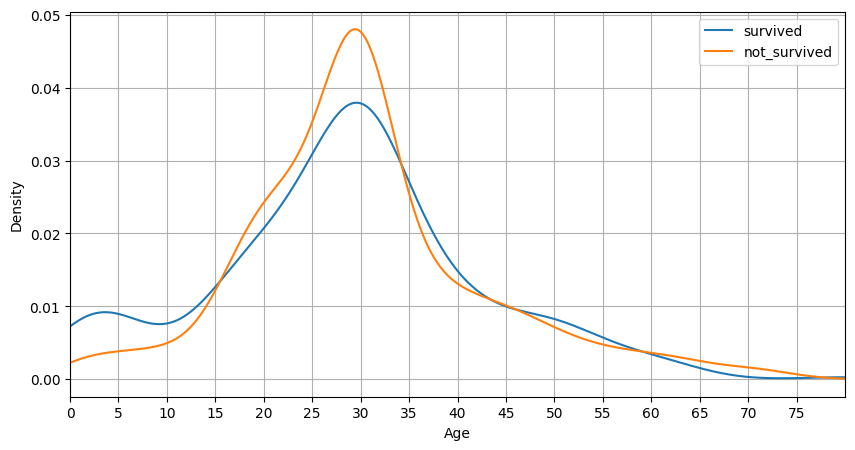

In [51]:
# Survivers by Age
survive_chance_by('Age', np.arange(0, 80, 5), (0, 80))

By curves intersection points we can separate 5 age groups

In [52]:
df['Age_group'] = pd.cut(x=df.Age, labels=[5, 1, 4, 3, 2],
                         bins=[-1, 15, 33, 45, 60, df.Age.max()]).astype('float')

# Create Family_group

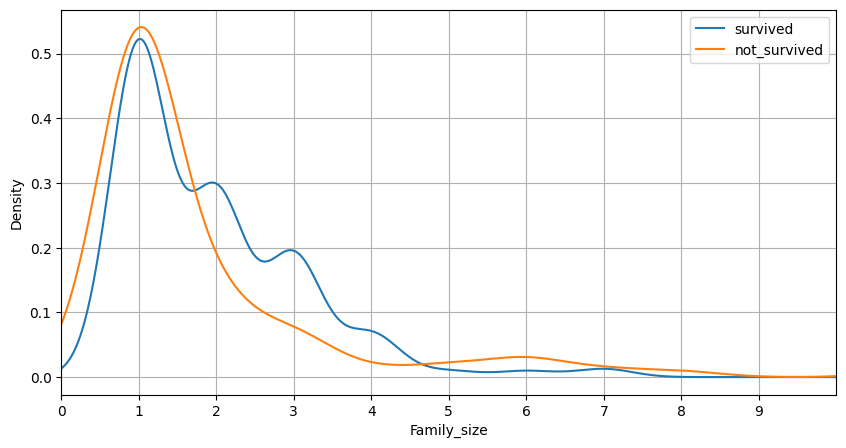

In [53]:
# Survivers by Family_size
survive_chance_by('Family_size', np.arange(0, 10, 1), (0, 10))

Here we can separate 3 groups:

    1. Single persons had lower chance to survive
    2. 2-4 members families had higher chances, as they had some priority to safeboats with 1-2 children with them
    3. 5 and more members families had almost equal chances

In [54]:
# Create Family_group feature
df['Family_group'] = pd.cut(x=df.Family_size, labels=[1, 3, 2], 
                            bins=[-1, 1, 4, df.Family_size.max()]).astype('float')

# Create Lucky_family
To create this feature we analyse earlier created Family_survivers that used by itself would overfit the model

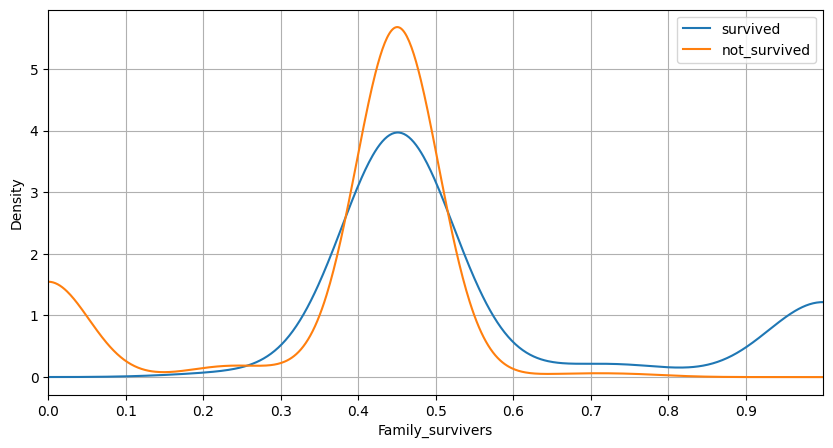

In [55]:
# Survivers by Family_survivers
survive_chance_by('Family_survivers', np.arange(0, 1, 0.1), (0, 1))

By curves intersection points we can separate 4 family groups with different chance to survive

In [56]:
# Create Lucky_family feature
df['Lucky_family'] = pd.cut(x=df.Family_survivers, labels=[2, 3, 1, 4],
                            bins=[-1, 0.22, 0.35, 0.49, df.Family_survivers.max()]).astype('float')

# Standardization

In [57]:
# Apply np.log to normalize the skewed right Price
df.Price = df.Price.apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [58]:
# Drop features not used for modeling
cols_to_drop = ['Family_survivers']
df = df.drop(cols_to_drop, axis=1)

# Split train and test data

In [59]:
X = df[:X_max_index]
test_df = df[X_max_index:]

# Processed data correlation

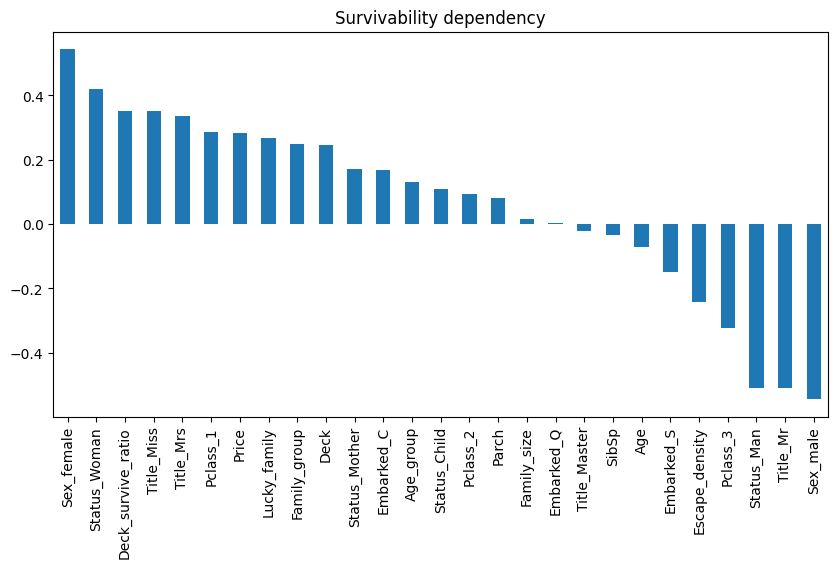

In [60]:
# Concatenate into a full dataset
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

# Conclusion

On the Titanic is better to not be an usual single adult male on a lower deck and embarked from Southampton with a cheap ticket in the pocket - RIP Jack Dawson :-(

# CatBoost grid search parameter tuning
This cell is commented out as it takes long time to run and the resulted parameters are shown further

In [61]:
# # Define model
# cat_model = CatBoostClassifier()

# # Define parameters' grid
# grid = {'verbose': [False],
#         'thread_count': [-1],
#         'depth': [3, 4, 5, 6],
#         'iterations': [500, 1000, 2000, 3000],
#         'learning_rate': [0.0001, 0.001, 0.01]}

# # Define GridSearchCV
# grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
# grid_cat.fit(X[final_features], y)

# params = grid_cat.best_params_

# print('\n Best Score:\n', grid_cat.best_score_)
# print('\n Best parameters:\n', params)

# CatBoost model

In [62]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
import numpy as np
import catboost
from sklearn.model_selection import train_test_split

# 假设你已经有一个 DataFrame df，其中 X_max_index 是分割数据的索引
X = df.iloc[:X_max_index]
test_df = df.iloc[X_max_index:]

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set up CatBoost parameters
catboost_params = {
    'verbose': False,
    'thread_count': -1,
    'depth': 4, 
    'iterations': 1000, 
    'learning_rate': 0.0005,
}

# Perform cross-validation with CatBoost
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

best_test_accuracy = 0
best_test_predictions = []

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create CatBoost datasets
    train_data_fold = catboost.Pool(X_train_fold, label=y_train_fold)
    valid_data_fold = catboost.Pool(X_valid_fold, label=y_valid_fold)

    # Train the CatBoost model
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_data_fold, eval_set=valid_data_fold, early_stopping_rounds=10)

    # Make predictions on the validation set
    valid_predictions_fold = model.predict(X_valid_fold)

    # Calculate accuracy on the validation set
    valid_accuracy_fold = accuracy_score(valid_predictions_fold, y_valid_fold)

    # If the current model has a higher accuracy on the validation set, update the best model
    if valid_accuracy_fold > best_test_accuracy:
        best_test_accuracy = valid_accuracy_fold
        best_test_predictions = model.predict(X_test)

# Print best testing accuracy
print(f'Best Testing Accuracy: {best_test_accuracy}')


Best Testing Accuracy: 0.8811188811188811


# Submission

In [63]:
# Make predictions which we will submit.
test_preds = model.predict(test_df)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Survived': test_preds})
output.to_csv('submission_test.csv', index=False)